In [5]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.datasets import imdb
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

2023-12-19 05:49:51.426870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 05:49:51.426928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 05:49:51.428756: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 05:49:51.446507: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 05:49:53.124298: W tensorflow/compiler/tf2

AttributeError: partially initialized module 'keras.src' has no attribute 'utils' (most likely due to a circular import)

In [ ]:
max_features = 20000
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
L1 = 100
L2 = 10
x_train, y_train, x_test, y_test = x_train[:L1], y_train[:L1], x_test[:L2], y_test[:L2]

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Loading data...
100 train sequences
10 test sequences


In [ ]:
print(x_train.shape)
x_train[0]

(100, 80)


array([   15,   256,     4,     2,     7,  3766,     5,   723,    36,
          71,    43,   530,   476,    26,   400,   317,    46,     7,
           4, 12118,  1029,    13,   104,    88,     4,   381,    15,
         297,    98,    32,  2071,    56,    26,   141,     6,   194,
        7486,    18,     4,   226,    22,    21,   134,   476,    26,
         480,     5,   144,    30,  5535,    18,    51,    36,    28,
         224,    92,    25,   104,     4,   226,    65,    16,    38,
        1334,    88,    12,    16,   283,     5,    16,  4472,   113,
         103,    32,    15,    16,  5345,    19,   178,    32],
      dtype=int32)

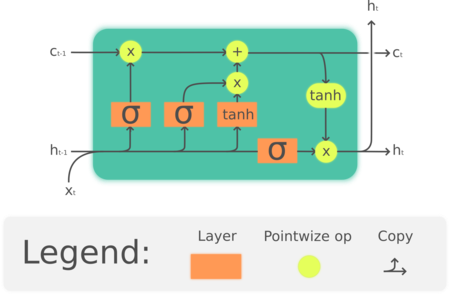

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz

        #i_t
        self.W_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))

        #f_t
        self.W_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))

        #c_t
        self.W_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))

        #o_t
        self.W_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))

    #     self.init_weights()

    # def init_weights(self):
    #     stdv = 1.0 / np.sqrt(self.hidden_size)
    #     for weight in self.parameters():
    #         weight.data.uniform_(-stdv, stdv)

    def forward(self,x,init_states=None):
        bs, seq_sz, _ = x.size()
        hidden_seq = []

        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size),
                torch.zeros(bs, self.hidden_size),
            )
        else:
            h_t, c_t = init_states

        for t in range(seq_sz):
            x_t = x[:, t, :]

            i_t = torch.sigmoid(x_t @ self.W_i + h_t @ self.U_i + self.b_i)
            f_t = torch.sigmoid(x_t @ self.W_f + h_t @ self.U_f + self.b_f)
            g_t = torch.tanh(x_t @ self.W_c + h_t @ self.U_c + self.b_c)
            o_t = torch.sigmoid(x_t @ self.W_o + h_t @ self.U_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.word_embeddings = nn.Embedding(max_features, 128)
        self.lstm = LSTM(128,128)
        self.hidden2label = nn.Linear(128, 2)#(hidden_dim, label_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(1, 1, 128)),
                autograd.Variable(torch.zeros(1, 1, 128)))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        x = embeds.view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y  = self.hidden2label(lstm_out[:,0,-1,:])
        log_probs = F.log_softmax(y)
        return log_probs

In [ ]:
model = LSTMClassifier()

model(Variable(torch.from_numpy(x_train[0]).long()))
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-3)

def evaluate(model, data_x, data_y, loss_function):
    model.eval()
    avg_loss = 0.0
    truth_res = []
    pred_res = []
    for rep in range(len(data_x)):
        y = np.ndarray(1)
        y[0] = data_y[rep]
        truth_res.append(y[0])
        y = Variable(torch.from_numpy(y).long())
        # detaching it from its history on the last instance.
        # model.hidden = model.init_hidden()
        pred = model(Variable(torch.from_numpy(data_x[rep]).long()))
        pred_label = pred.data.max(1)[1].numpy()
        pred_res.append(pred_label)
        loss = loss_function(pred, y)
        avg_loss += loss.data.item()
    avg_loss /= len(data_x)
    acc = get_accuracy(truth_res, pred_res)
    print('avg_loss:%g train acc:%g' % (avg_loss, acc ))
    return acc



def get_accuracy(truth, pred):
     assert len(truth)==len(pred)
     right = 0
     for i in range(len(truth)):
         if truth[i]==pred[i]:
             right += 1.0
     return right/len(truth)


def train_epoch(model, train_data_x, train_data_y, loss_function, optimizer, i):
    model.train()
    avg_loss = 0.0
    count = 0
    truth_res = []
    pred_res = []
    batch_sent = []
    prev_loss = 0.0
    for rep in range(len(train_data_x)):
        y = np.ndarray(1)
        y[0] = train_data_y[rep]
        truth_res.append(y[0])
        y = Variable(torch.from_numpy(y).long())
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()
        pred = model(Variable(torch.from_numpy(train_data_x[rep]).long()))
        pred_label = pred.data.max(1)[1].numpy()
        pred_res.append(pred_label)
        model.zero_grad()
        loss = loss_function(pred, y)
        avg_loss += loss.data.item()
        prev_loss += loss.data.item()
        count += 1
        if count % 200 == 0:
            print('epoch: %d iterations: %d loss :%g' % (i, count, prev_loss))
            print(f'acc {get_accuracy(truth_res,pred_res)}')
            prev_loss = 0.0
        loss.backward()
        optimizer.step()
    avg_loss /= len(train_data_x)
    print('epoch: %d done! \n train avg_loss:%g , acc:%g'%(i, avg_loss, get_accuracy(truth_res,pred_res)))


EPOCH = 4
for i in range(EPOCH):
    print('epoch: %d start!' % i)
    train_epoch(model, x_train, y_train, loss_function, optimizer, i)

epoch: 0 start!


<ipython-input-75-3b2b97380402>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs = F.log_softmax(y)


AttributeError: ignored

In [ ]:
evaluate(model, x_test, y_test, loss_function)